In [6]:
import pickle
import os
import numpy as np
import torch
from itertools import cycle
import matplotlib.pyplot as plt
import pennylane as qml
from itertools import combinations
from sklearn.metrics import balanced_accuracy_score, f1_score
# from utils import Optimizer
from pytorch_minimize.optim import MinimizeWrapper 
import random

# Need this to resolve paths pater
base_path = os.getcwd()

# Set random seeds for reproducibility
seed_num = 1993
torch.manual_seed(seed_num)
random.seed(seed_num)
np.random.seed(seed_num)

In [7]:
def data_santity_check(data):
    X = np.asarray(data)
    # Only accept 3d data. (\boldsymbol, d, p)
    if len(X.shape) != 3:
        raise TypeError("Dimensions of X \boldsymbolust be 3 dimensional: (num_series, num_features, num_time_points)")

In [8]:
class DataGetter:
    def __init__(self, X, batch_size):
        self.batch_size = batch_size
        self.data = []
        self.X = X
        self._init_data(
            iter(
                torch.utils.data.DataLoader(
                    self.X, batch_size=self.batch_size, shuffle=True)))

    def _init_data(self, iterator):
        x = next(iterator, None)
        while x is not None:
            self.data.append(x)
            x = next(iterator, None)

    def __next__(self):
        try:
            return self.data.pop()
        except(IndexError):
            self._init_data(
                iter(
                    torch.utils.data.DataLoader(
                        self.X, batch_size=self.batch_size, shuffle=True)))
            return self.data.pop()


def get_series_training_cycler(Xtr, n_series_batch):
    x_cycler = DataGetter(Xtr, n_series_batch)
    return x_cycler

def get_timepoint_training_cycler(Xtr, n_t_batch):
    n_time_points = Xtr.shape[2]
    T  = torch.tensor(np.arange(n_time_points))
    t_cycler = DataGetter(T, n_t_batch)
    return t_cycler



In [9]:
# Work explicitly with 2 qubits. This corresponds to the 'bivariate model' in the article
n_qubits = 2

@qml.qnode(qml.device('lightning.qubit', wires=n_qubits, shots=None), interface='torch')
def get_anomaly_expec(x, t, D, alpha, wires, k, embed_func, transform_func, diag_func, observable,
                      embed_func_params={}, transform_func_params={}):

    embed_func(x, wires=wires, **embed_func_params) # U[x_i(t_j)]
    transform_func(alpha, wires, **transform_func_params) # W(\alpha)
    diag_func(D * t, n_qubits, k=k) # D(\epsilon, t_j)
    qml.adjoint(transform_func)(alpha, wires=range(n_qubits), **transform_func_params
        ) # W^{\dagger}(\alpha)

    # plug in \hat{O}_{\eta}
    coeffs = np.ones(len(wires))/len(wires) # scale by 1/n
    H = qml.Hamiltonian(coeffs, observable)
     # calculate expecation
    return qml.expval(H)

In [10]:
def create_diagonal_circuit(D, n, k=None):
    # D is a sub-set of the exponential number of eigenvalues.
    if k is None:
        k = n
    cnt = 0
    # Note there NO explicit loop over all 2^n eigenvalues
    for i in range(1, k + 1):
        for comb in combinations(range(n), i):
            if len(comb) == 1:
                qml.RZ(D[cnt], wires=[comb[0]])
                cnt += 1
            elif len(comb) > 1:
                cnots = [comb[i : i + 2] for i in range(len(comb) - 1)]
                for j in cnots:
                    qml.CNOT(wires=j)
                qml.RZ(D[cnt], wires=[comb[-1]])
                cnt += 1
                for j in cnots[::-1]:
                    qml.CNOT(wires=j)

In [11]:
def get_single_point_cost(x, t, alpha, eta_0, M_sample_func, sigma, mu, N_E, wires,
                          k, embed_func, transform_func, diag_func, observable,
                          embed_func_params={}, transform_func_params={}):
    expecs = torch.zeros(N_E)
    for i in range(N_E):
        D = M_sample_func(sigma, mu)
        expec = get_anomaly_expec(x, t, D, alpha, wires, k, embed_func, transform_func, diag_func, observable,
                                   embed_func_params={}, transform_func_params={})
        expecs[i] = expec
    mean = expecs.mean()
    # eta_0 separated from expectation expression since it was an identity matrix prefactor
    single_point_cost = (eta_0 - mean)**2/4 # 1/4 factor fom L = 4 in article
    return single_point_cost

In [12]:
def sample_M(sigma, mu):
    # Sample from a normal distribution
    D = torch.normal(mu, sigma.abs())
    return D


In [13]:
def get_time_series_cost(xt, alpha, eta_0, M_sample_func, sigma, mu, N_E, wires, k, embed_func,
                         transform_func, diag_func, observable, t_cycler, embed_func_params={},
                         transform_func_params={}, start=0.1, end=2*np.pi):
    if t_cycler is None:
        t_idxs = np.arange(xt.shape[1])
        ts = np.linspace(start, end, xt.shape[1], endpoint=True)
    else:
        t_idxs = next(t_cycler)
        ts = np.linspace(start, end, xt.shape[1], endpoint=True)[t_idxs]
    xt_batch = xt[:, t_idxs]
    xfunct = zip(xt_batch.T, ts)
    a_func_t = \
        [get_single_point_cost(x, t, alpha, eta_0, M_sample_func, sigma, mu, N_E, wires,
                               k, embed_func, transform_func, diag_func, observable) for x, t in xfunct]
    single_time_series_cost = torch.tensor(a_func_t, requires_grad=True).mean()
    return single_time_series_cost

In [14]:
def get_loss(alpha, eta_0, M_sample_func, sigma, mu, N_E, wires, k, embed_func,
            transform_func, diag_func, observable, t_cycler, x_cycler, penalty, tau, embed_func_params={},
            transform_func_params={}):

    X_batch = next(x_cycler)
    single_costs = torch.zeros(X_batch.shape[0])
    for i, xt in enumerate(X_batch):
        single_time_series_cost = \
            get_time_series_cost(xt, alpha, eta_0, M_sample_func, sigma, mu, N_E, wires, k, embed_func,
                                 transform_func, diag_func, observable, t_cycler, embed_func_params={},
                                 transform_func_params={})
        single_costs[i] = single_time_series_cost
    loss = 0.5*single_costs.mean() + penalty(sigma, tau)
    return loss

In [15]:
def arctan_penalty(sigma, contraction_hyperparameter):
    prefac = 1/(np.pi)
    sum_terms = torch.arctan(2*np.pi*contraction_hyperparameter*torch.abs(sigma))
    mean = sum_terms.mean()
    return prefac*mean

In [16]:
class Optimizer:
    def __init__(
        self,
        function,
        variables,
        optimizer_parameters=dict(
            method="COBYLA", options={"disp": True, "maxiter": 10}, jac=False
        ),
    ):
        self.function = function
        self.variables = variables
        self.optimizer_parameters = optimizer_parameters
        self.optimizer = MinimizeWrapper(list(self.variables.values()), self.optimizer_parameters)
        self.loss_iterations = []

    def optimize(
        self,
    ):
        def closure():
            self.optimizer.zero_grad()
            loss = self.function(**self.variables)
            self.loss_iterations.append(float(loss))
            loss.backward()
            return loss

        self.optimizer.step(closure=closure)
        return self.variables

    def get_loss_iterations(self):
        return self.loss_iterations



In [17]:
def get_initial_parameters(transform_func, transform_func_layers, n_qubits, num_distributions):
    initial_alpha =\
         torch.tensor(np.random.uniform(0, 2 * np.pi, size=transform_func.shape(transform_func_layers, n_qubits)),
         requires_grad=True).type(torch.DoubleTensor)
    initial_mu = torch.tensor(
                np.random.uniform(0, 2 * np.pi, num_distributions)).type(torch.DoubleTensor)
    initial_sigma = torch.tensor(
                np.random.uniform(0, 2 * np.pi, num_distributions)).type(torch.DoubleTensor)
    initial_eta_0 = torch.tensor(np.random.uniform(-1, 1)).type(torch.DoubleTensor)
    init_parameters = {'alpha': initial_alpha, 'mu': initial_mu, 'sigma': initial_sigma, 'eta_0': initial_eta_0}
    return init_parameters

In [18]:
# Generate sets X and F
def get_1d_training_time_series(noise_level, n_t_points, n_series):
    # Generate a synthetic training set with defined noise about the origin
    Xtr = np.zeros(shape=(n_series, 1, n_t_points))
    for i in range(n_series):
        Xtr[i, 0, :] = np.random.normal(0, noise_level, n_t_points)
    return Xtr

In [19]:
def get_1d_testing_time_series(occurance, small_anomaly, large_anomaly,
                               length_anomaly, gap, n_series):
    # Generate a synthetic testing set with obviously visible anomalies compared with training
    # Series has length: length_anomaly * gap
    Xte = np.zeros(shape=(n_series, 1, length_anomaly*gap))
    for i in range(n_series):
        event = np.random.choice([1, 0], size=length_anomaly, p=[occurance, 1-occurance])
        Xte[i, 0, :] = np.array([np.random.normal(0, [small_anomaly, large_anomaly][j], gap) for j in event]).flatten()
    return Xte

# Generate set H
def get_1d_noisy_sin(noise_amp, n_series, n_time):
    Xtr_sin = np.zeros(shape=(n_series, 1, n_time))
    # Sin functions are 2sinx so we don't need feature scaling later (+ noise < 2pi range)
    for i in range(Xtr_sin.shape[0]):
        sin1 = 2*np.sin(np.linspace(0, 2*np.pi, n_time))
        sin1 = sin1 + np.random.uniform(low=-noise_amp, high=noise_amp, size=sin1.shape)
        Xtr_sin[i, 0, :] = sin1
    return Xtr_sin

In [20]:
# Create 50 time series for each set
n_series = 50
time_points = 50

Xtr = get_1d_training_time_series(0.5, time_points, n_series)
Xte_normal = get_1d_training_time_series(0.5, time_points, n_series)
Xte_spikes = get_1d_testing_time_series(0.2, 0.3, 1.6, 5, 10, n_series)
Xte_sin = get_1d_noisy_sin(0.5, n_series, time_points)

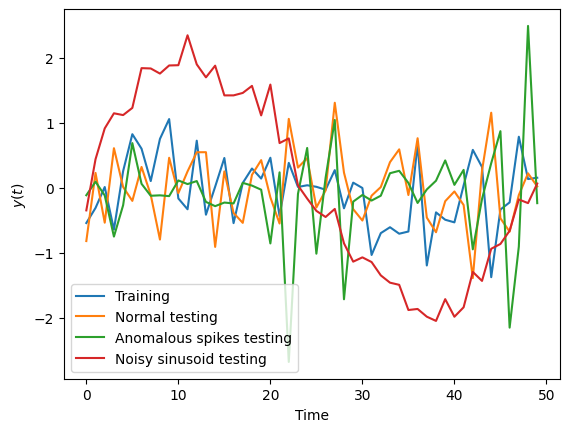

In [21]:
plt.figure()
plt.plot(Xtr[0, 0, :], label="Training")
plt.plot(Xte_normal[0, 0, :], label="Normal testing")
plt.plot(Xte_spikes[0, 0, :], label="Anomalous spikes testing")
plt.plot(Xte_sin[0, 0, :], label="Noisy sinusoid testing")
plt.ylabel("$y(t)$")
plt.xlabel("Time")
plt.legend()

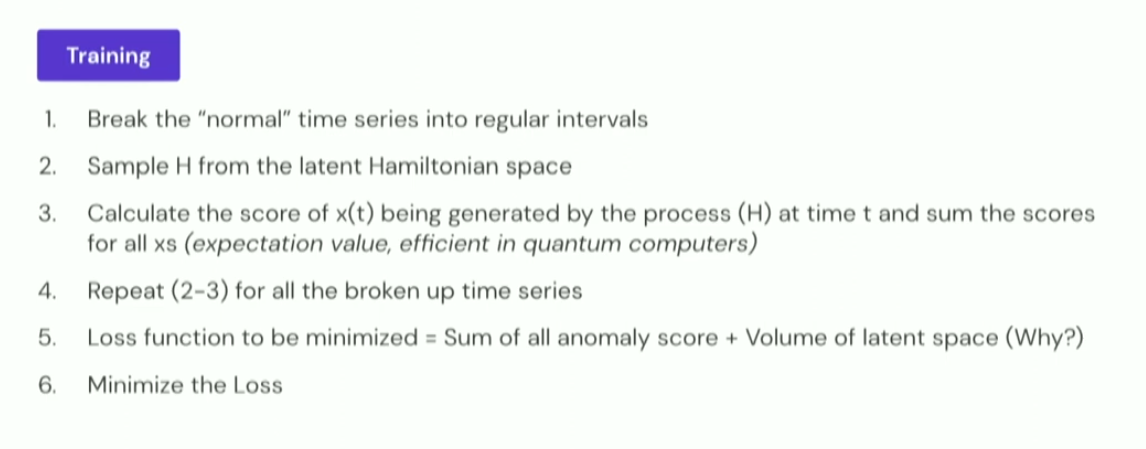

In [22]:
Xtr=Xtr
n_series_batch=1
n_t_batch=10
num_distributions=3
transform_func=qml.templates.StronglyEntanglingLayers
n_qubits=2
transform_func_layers=1,
embed_func=qml.templates.AngleEmbedding
N_E=10
k=2
observable=[qml.PauliZ(i) for i in range(n_qubits)]
tau=10
optimizer_params={"method": "Powell",
                  "options": {"disp": True, "maxfev": 1000,
                              "jac": False, "maxiter": 1000}, "jac": False}

In [23]:
def train_model(initial_parameters, M_sample_func, N_E, wires, k, embed_func, n_qubits,
                transform_func, diag_func, observable, t_cycler, x_cycler, penalty, tau,
                optimizer_params):
    alpha = initial_parameters['alpha']
    mu = initial_parameters['mu']
    sigma = initial_parameters['sigma']
    eta_0 = initial_parameters['eta_0']
    f = lambda alpha, mu, sigma, eta_0: get_loss(alpha=alpha, mu=mu, sigma=sigma, eta_0=eta_0,
                                             M_sample_func=M_sample_func, N_E=N_E, wires=range(n_qubits),
                                             k=k, embed_func=embed_func, transform_func=transform_func,
                                             diag_func=diag_func, observable=observable,
                                             t_cycler=t_cycler, x_cycler=x_cycler,
                                             penalty=penalty, tau=tau)
    optimizer = Optimizer(f, initial_parameters, optimizer_params)
    opt_params = optimizer.optimize()
    loss_history = optimizer.get_loss_iterations()
    return {"opt_params": opt_params, "loss_history": loss_history}

In [24]:
def training_workflow_modified(Xtr, n_series_batch, n_t_batch, transform_func, n_qubits,
                               transform_func_layers, embed_func, N_E, k, observable, tau, optimizer_params,
                               num_distributions):
    # check dimensions of input data are correct
    data_santity_check(Xtr)

    # Get dataloaders for series and time-point batches
    x_cycler = get_series_training_cycler(Xtr, n_series_batch)
    t_cycler = get_timepoint_training_cycler(Xtr, n_t_batch)

    # get penalty function
    penalty = arctan_penalty

    # get sampling function
    sampler = sample_M

    # get random initial parameters
    init_parameters = get_initial_parameters(transform_func, transform_func_layers, n_qubits, num_distributions)

    # Run training
    opt_results = train_model(init_parameters, sample_M, N_E, range(n_qubits), k, embed_func, n_qubits,
                              transform_func, create_diagonal_circuit, observable, t_cycler, x_cycler,
                              penalty, tau, optimizer_params)
    return opt_results

In [ ]:
opt_results = training_workflow_modified(Xtr=Xtr,
                      n_series_batch=1,
                      n_t_batch=10,
                      num_distributions=3,
                      transform_func=qml.templates.StronglyEntanglingLayers,
                      n_qubits=2,
                      transform_func_layers=1,
                      embed_func=qml.templates.AngleEmbedding,
                      N_E=10,
                      k=2,
                      observable=[qml.PauliZ(i) for i in range(n_qubits)],
                      tau=10,
                      optimizer_params={"method": "Powell",
                                        "options": {"disp": True, "maxfev": 1000,
                                                    "jac": False, "maxiter": 1000}, "jac": False})

/home/anujtiwari/Programming/QuantumML/.venv/lib/python3.12/site-packages/pytorch_minimize/optim.py:116: OptimizeWarning: Unknown solver options: jac
  return minimize(func, x0, **minimizer_args)


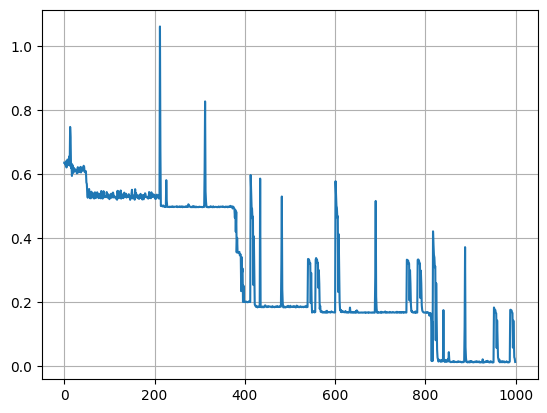

In [ ]:
plt.plot(opt_results['loss_history'])

plt.grid()

In [ ]:
def get_anomaly_scores(Xte, penalty, tau, results_dict, M_sample_func, wires, k, embed_func, N_E,
                       transform_func, diag_func, observable):
    opt_params = results_dict['opt_params']
    alpha = opt_params['alpha']
    mu = opt_params['mu']
    sigma = opt_params['sigma']
    eta_0 = opt_params['eta_0']
    normal_cost = np.min(results_dict['loss_history'])
    scores = torch.zeros(Xte.shape[0])
    for i, yt in enumerate(Xte):
        single_time_series_cost =\
            get_time_series_cost(yt, alpha, eta_0, M_sample_func, sigma, mu, N_E, wires, k, embed_func,
                         transform_func, diag_func, observable, t_cycler=None)
        # scores[i] = (normal_cost - 0.5*single_time_series_cost - penalty(sigma, tau)).abs()
        anom_score = 2*normal_cost - 2*penalty(sigma, tau) - single_time_series_cost
        scores[i] = single_time_series_cost
    return scores

In [ ]:
def anomaly_score_workflow(Xte, penalty, tau, results_dict, M_sample_func, wires, k, embed_func, N_E, transform_func,
                           diag_func, observable):

    # check dimensions of input data are correct
    data_santity_check(Xte)

    scores = get_anomaly_scores(Xte, penalty, tau, results_dict,
                                 M_sample_func, wires, k, embed_func, N_E,
                                 transform_func, diag_func, observable)

    return scores

In [ ]:
dispatch_ids = []
for Xte in [Xte_normal, Xte_spikes, Xte_sin]:
    dispatch_id = anomaly_score_workflow(Xte=Xte,
                                               penalty=arctan_penalty,
                                               tau=10,
                                               results_dict=opt_results,
                                               M_sample_func=sample_M,
                                               wires=range(n_qubits),
                                               k=2,
                                               embed_func=qml.templates.AngleEmbedding,
                                               N_E=10,
                                               transform_func=qml.templates.StronglyEntanglingLayers,
                                               diag_func=create_diagonal_circuit,
                                               observable=[qml.PauliZ(i) for i in range(n_qubits)])
    dispatch_ids.append(dispatch_id)



In [ ]:
all_scores = dispatch_ids

/tmp/ipython-input-47-2109831187.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes = plt.boxplot([scores.detach().numpy() for scores in all_scores], labels=['Normal', 'Spikes', "Sin added"])


Text(0, 0.5, 'Anomaly score')

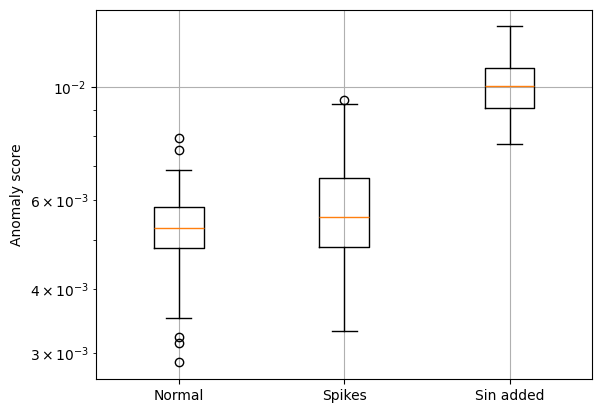

In [ ]:
boxes = plt.boxplot([scores.detach().numpy() for scores in all_scores], tick_labels=['Normal', 'Spikes', "Sin added"])
plt.grid()
plt.yscale('log')
plt.ylabel('Anomaly score')

In [ ]:
def get_anomaly_scores_at_each_time_point(Xte, penalty, tau, results_dict, M_sample_func, wires, k, embed_func, N_E,
                       transform_func, diag_func, observable):
    opt_params = results_dict['opt_params']
    alpha = opt_params['alpha']
    mu = opt_params['mu']
    sigma = opt_params['sigma']
    eta_0 = opt_params['eta_0']

    # Initialize a list to store per-timepoint scores for each series
    all_series_timepoint_scores = [] # Changed from 'scores' to 'all_series_timepoint_scores'

    for i, yt in enumerate(Xte):
        # We need the individual time point costs (a_func_t)
        # Re-implementing the core logic from get_time_series_cost here
        # to get the individual costs for each time point
        if yt.shape[1] > 0: # Ensure there are time points
            t_idxs = np.arange(yt.shape[1])
            # Ensure start and end are consistent with how ts are generated in get_time_series_cost
            # Default values are 0.1 and 2*np.pi
            ts = np.linspace(0.1, 2*np.pi, yt.shape[1], endpoint=True)
        else:
            ts = [] # Handle empty time series case for safety

        xt_batch = yt[:, t_idxs]
        xfunct = zip(xt_batch.T, ts)

        # This list holds the individual anomaly scores for each time point in the current series 'yt'
        individual_timepoint_costs = \
            [get_single_point_cost(x, t, alpha, eta_0, M_sample_func, sigma, mu, N_E, wires,
                                   k, embed_func, transform_func, diag_func, observable) for x, t in xfunct]

        # Convert to torch tensor and append to the list
        all_series_timepoint_scores.append(torch.tensor(individual_timepoint_costs))

    return all_series_timepoint_scores # Now returns a list of tensors, each tensor is a series' time-point scores

In [ ]:
def anomaly_score_at_each_time_point_workflow(Xte, penalty, tau, results_dict, M_sample_func, wires, k, embed_func, N_E, transform_func,
                           diag_func, observable):

    # check dimensions of input data are correct
    data_santity_check(Xte)

    scores = get_anomaly_scores_at_each_time_point(Xte, penalty, tau, results_dict,
                                 M_sample_func, wires, k, embed_func, N_E,
                                 transform_func, diag_func, observable)

    return scores

In [ ]:
dispatch_ids = []
for Xte in [Xte_normal, Xte_spikes, Xte_sin]:
    dispatch_id = anomaly_score_at_each_time_point_workflow(Xte=Xte,
                                               penalty=arctan_penalty,
                                               tau=10,
                                               results_dict=opt_results,
                                               M_sample_func=sample_M,
                                               wires=range(n_qubits),
                                               k=2,
                                               embed_func=qml.templates.AngleEmbedding,
                                               N_E=10,
                                               transform_func=qml.templates.StronglyEntanglingLayers,
                                               diag_func=create_diagonal_circuit,
                                               observable=[qml.PauliZ(i) for i in range(n_qubits)])
    dispatch_ids.append(dispatch_id)



In [ ]:
time_series_normal = Xte_normal[0, 0, :]

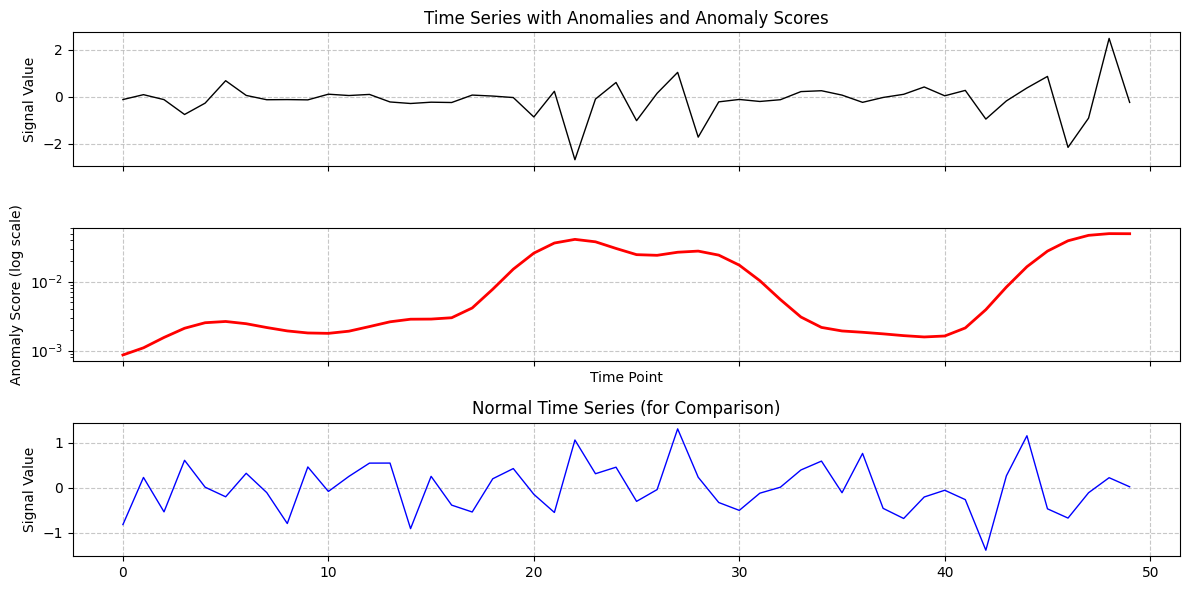

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.ndimage import gaussian_filter1d

per_timepoint_scores_list = dispatch_ids[1]


# Select the anomalous time series for plotting (e.g., the first one from Xte_spikes)
time_series_to_plot = Xte_spikes[0, 0, :] # Get the first series, first feature

# Get the anomaly scores for the first series from the list
raw_anomaly_scores_for_plot = per_timepoint_scores_list[0].numpy()

# --- Post-processing for a smoother plot with a baseline ---

# 1. Smoothing (Gaussian filter for example)
# Adjust sigma for more or less smoothing. A larger sigma means more smoothing.
smoothed_anomaly_scores = gaussian_filter1d(raw_anomaly_scores_for_plot, sigma=2) # Experiment with sigma

# 2. Apply a conceptual 'threshold' or baseline
# For demonstration, let's find a "normal" baseline value from the raw scores,
# e.g., a percentile from the normal data, or a low value.
# You could use the 'best_zeta' from a validation workflow if you run that.
# Here, we'll just use a small arbitrary value or a low percentile for normal.
# Let's assume a baseline level, below which we consider scores "normal"
# You might want to calculate a proper threshold from your normal data (e.g., Xte_normal scores)
# For now, let's just use the minimum non-zero value or a very small number for the baseline.
# The `1e-8` is a placeholder for a 'normal' level if scores go very low.
baseline_level = np.mean(raw_anomaly_scores_for_plot[raw_anomaly_scores_for_plot < np.percentile(raw_anomaly_scores_for_plot, 50)])
if baseline_level == 0:
    baseline_level = 1e-8 # Prevent log(0) issues

# Set scores below a certain level to the baseline
# You could also use a learned threshold 'best_zeta' from your validation if available.
# For this example, let's use a dynamic threshold based on the data's general distribution.
# A more robust approach would be to use your 'best_zeta' from a validation set.
# For illustration, let's try setting anything below a certain percentile to a baseline.
threshold_for_plotting = np.percentile(raw_anomaly_scores_for_plot, 10) # Example: 10th percentile
# Or, if you have 'best_zeta' from QVR_acquisition.py testing phase, use that.
# For now, let's just plot the smoothed scores to avoid hard clipping and see the bumps.

# Create the figure and subplots
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 6))
# Plot 3: Normal Time Series (for comparison)
ax3.plot(time_series_normal, color='blue', linewidth=1)
ax3.set_ylabel('Signal Value')
ax3.set_title('Normal Time Series (for Comparison)')
ax3.grid(True, linestyle='--', alpha=0.7)

# Plot the time series data on the top subplot
ax1.plot(time_series_to_plot, color='black', linewidth=1)
ax1.set_ylabel('Signal Value')
ax1.set_title('Time Series with Anomalies and Anomaly Scores')
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot the smoothed anomaly scores on the bottom subplot
ax2.plot(smoothed_anomaly_scores, color='red', linewidth=2)
ax2.set_xlabel('Time Point')
ax2.set_ylabel('Anomaly Score (log scale)')
ax2.set_yscale('log') # Keep log scale as in your previous request and example plot
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

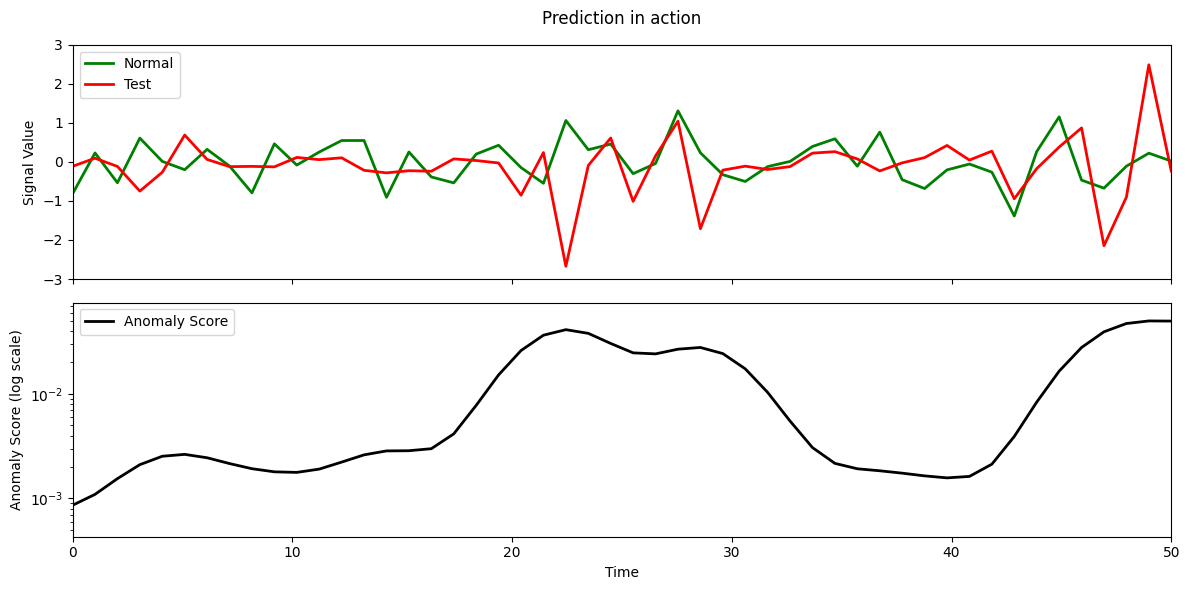

In [ ]:
import matplotlib.animation as animation

# Prepare the data
normal_data = time_series_normal
test_data = time_series_to_plot
anomaly_data = smoothed_anomaly_scores

# Create the figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
time = np.linspace(0,50,len(normal_data))

# Set the x and y axis limits
ax1.set_xlim(0, 50)
ax1.set_ylim(-3,3)
ax2.set_yscale('log')
ax2.set_ylim(min(anomaly_data) * 0.5, max(anomaly_data) * 1.5)

# Create empty lines with different colors
normal_line, = ax1.plot([], [], lw=2, color='green', label='Normal')
test_line, = ax1.plot([], [], lw=2, color='red', label='Test')

# Add legend
ax1.legend(loc='upper left')


# Add title and labels
ax1.set_title('Prediction in action', pad=15)

ax1.set_ylabel('Signal Value')

ax2.set_xlabel('Time') # X-label only on the bottom plot (due to sharex)
ax2.set_ylabel('Anomaly Score (log scale)')

# Create empty line for ax2
anomaly_line, = ax2.plot([], [], lw=2, color='black', label='Anomaly Score') # Label for this specific line

ax2.legend(loc='upper left') # Legend for the anomaly plot

plt.subplots_adjust(bottom=0.1)

def animate(frame):
    # Update normal data
    normal_x = time[:frame+1]x
    normal_y = normal_data[:frame+1]
    normal_line.set_data(normal_x, normal_y)

    # Update test data
    test_x = time[:frame+1]
    test_y = test_data[:frame+1]
    test_line.set_data(test_x, test_y)

    # Update score data
    score_x = time[:frame+1]
    score_y = anomaly_data[:frame+1]
    anomaly_line.set_data(score_x, score_y)
    return normal_line, test_line, anomaly_line


# Create animation
anim = animation.FuncAnimation(
    fig,
    animate,
    frames=max(len(normal_data), len(test_data), len(anomaly_data)),
    interval=500,
    repeat=False,
    blit=True
)

anim.save('animation.gif', 'ffmpeg', fps=10)
# anim.save('animation.gif', writer='imagemagick', fps=60)
plt.tight_layout()
plt.show()

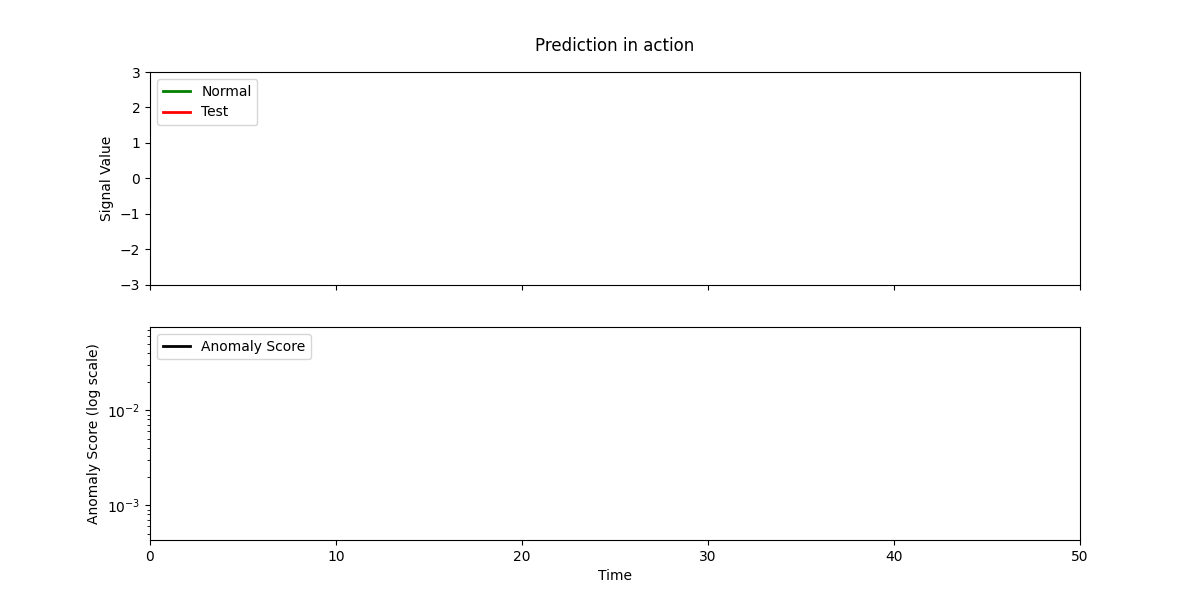